# MNIST

Ignore this code, this is just setup of various models and data loaders for MNIST. In this notebook we shall look at the vanishing gradient problem and see how multiple connections between weights in atrchitectures like the LSTM and Resnet work better than vanilla implmentations like a simple RNN or a very deep net without residual connections.

Please ignore this setup code and head on downwards to where we define our LSTM and RNN network.

In [1]:
from utils.vanishing_utils import *

# RNN

Here, we define our vanilla RNN network.

In [2]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.vis = True
    
    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.rnn(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        if self.vis:
          x.register_hook(lambda grad: vis_weights(grad))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# LSTM

We, we define our LSTM network.

In [3]:
# LSTM
class Lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Lstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.vis = True
    
    def forward(self, x):

        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        if self.vis:
          x.register_hook(lambda grad: vis_weights(grad))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


# Vanishing Gradient Visualization

Here, we will see the difference between the LSTM and RNN visually. We will plot the overall magnitude of the gradients (the loss with respect to the input sequence) across the whole input sequence. We shall see that the values of the gradients become really low as we go back to the start of the input sequence. 

The sequential multiplications of small gradients lead to smaller and smaller gradients as we back propagate through time. In the below graphs, the X axis corresponds to the index number of the input sequence and the Y axis corresponds to the mean value of the gradients at that position of the input.

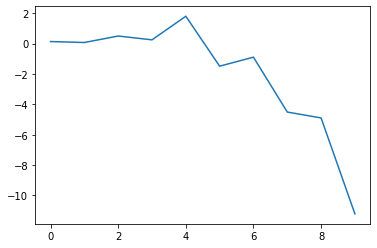

In [4]:
rnn_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
vis(rnn_model)

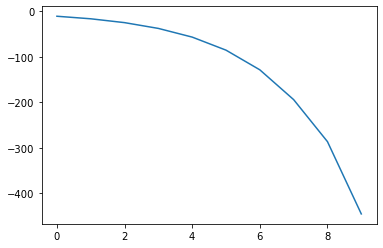

In [5]:
lstm_model = Lstm(input_size, hidden_size, num_layers, num_classes).to(device)
vis(lstm_model)

As, we can see the values for the LSTM are much bigger than the RNN.

The gradients for the first input in the sequence for LSTM are in the $10^{15}$ range and the gradients w.r.t first input of RNN are in the $10^{18}$ range.

This is a difference of about a factor of 1000. The gradients propogated behind are 1000 times smaller in the case of RNN over LSTM. This becomes a big problem when we want to sustain information over a long time span. 

## Difference in Performance in LSTM and RNN

Now, we shall use our intuitions of the vanishing gradient problem and verify that performance is indeed affected by comparing accuracy results on MNIST between the LSTM model and RNN model.

In [6]:
rnn_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
train_and_eval(rnn_model)

Epoch [1/2], Step [100/600], Loss: 2.2960
Epoch [1/2], Step [200/600], Loss: 2.3882
Epoch [1/2], Step [300/600], Loss: 2.3407
Epoch [1/2], Step [400/600], Loss: 2.3711
Epoch [1/2], Step [500/600], Loss: 2.4788
Epoch [1/2], Step [600/600], Loss: 2.3931
Epoch [2/2], Step [100/600], Loss: 2.3475
Epoch [2/2], Step [200/600], Loss: 2.3122
Epoch [2/2], Step [300/600], Loss: 2.3327
Epoch [2/2], Step [400/600], Loss: 2.3950
Epoch [2/2], Step [500/600], Loss: 2.3677
Epoch [2/2], Step [600/600], Loss: 2.3519
Test Accuracy of the model on the 10000 test images: 10.28 %


As we can see the, RNN is not able to learn to classify MNIST digits. Let's see if the LSTM network can do better with the same input sequence size...

In [7]:
lstm_model = Lstm(input_size, hidden_size, num_layers, num_classes).to(device)
train_and_eval(lstm_model)

Epoch [1/2], Step [100/600], Loss: 1.4245
Epoch [1/2], Step [200/600], Loss: 0.8804
Epoch [1/2], Step [300/600], Loss: 0.4939
Epoch [1/2], Step [400/600], Loss: 0.4153
Epoch [1/2], Step [500/600], Loss: 0.2987
Epoch [1/2], Step [600/600], Loss: 0.3564
Epoch [2/2], Step [100/600], Loss: 0.1449
Epoch [2/2], Step [200/600], Loss: 0.1908
Epoch [2/2], Step [300/600], Loss: 0.2162
Epoch [2/2], Step [400/600], Loss: 0.2465
Epoch [2/2], Step [500/600], Loss: 0.1229
Epoch [2/2], Step [600/600], Loss: 0.1081
Test Accuracy of the model on the 10000 test images: 95.19 %


The LSTM is able to learn something, all due to greater propagation of gradients backwards ! 